In [1]:
from selenium import webdriver
import pandas as pd
import nltk
from collections import Counter 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import string
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
import string
import operator
import io
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import itertools
from sklearn.manifold import MDS
import re
from collections import Counter, defaultdict
from itertools import combinations
import warnings
import csv
import itertools
from collections import defaultdict
from sklearn import manifold


# Scraper Engine

In [2]:
def scrape_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        messages = soup.find_all("div", class_ = "Message userContent")

        dates = soup.find_all("time")

        data = []

        for message, date in zip(messages, dates):
            message_text = message.get_text(strip = True)
            date_text = date.get("title")
            data.append({"Date": date_text, "Message": message_text})

        return data


def scrape_forum(base_url, total_pages):
    all_data = []

    for page_num in range(1, total_pages + 1):
        page_url = f"{base_url}/p{page_num}"
        print(f"Scraping page {page_num}: {page_url}")
        page_data = scrape_page(page_url)
        all_data.extend(page_data)
    return all_data

In [3]:
base_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
total_pages = 300
forum_data = scrape_forum(base_url, total_pages)
messagedata = pd.DataFrame(forum_data)
messagedata.to_csv("messagedata_final.csv", index = False)
len(messagedata)

Scraping page 1: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p1
Scraping page 2: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p2
Scraping page 3: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p3
Scraping page 4: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p4
Scraping page 5: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p5
Scraping page 6: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p6
Scraping page 7: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p7
Scraping page 8: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p8
Scraping page 9: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p9
S

15001

In [4]:
df = pd.read_csv('messagedata_final.csv')

In [5]:
# Remove messages with empty string
df = df[df['Message'] != '']
#Convert date to MM/DD/YYYY
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%Y')

## Task A
- Does the data support Zipf’s law econometrically?
- Plot the most common 100 words in the data against the theoretical prediction of the law.

In [6]:
# Does the data support Zipf's law?
# Plot the top 100 words against teoretical Zipf's law
top_words = df['Message'].str.split(expand=True).stack().value_counts()[:100]

top_words

the      72462
a        37960
to       30463
and      29697
I        26600
         ...  
If        1631
see       1623
make      1620
most      1597
could     1562
Name: count, Length: 100, dtype: int64

In [7]:
top_words.head()

the    72462
a      37960
to     30463
and    29697
I      26600
Name: count, dtype: int64

In [8]:
top_word_values = top_words.values

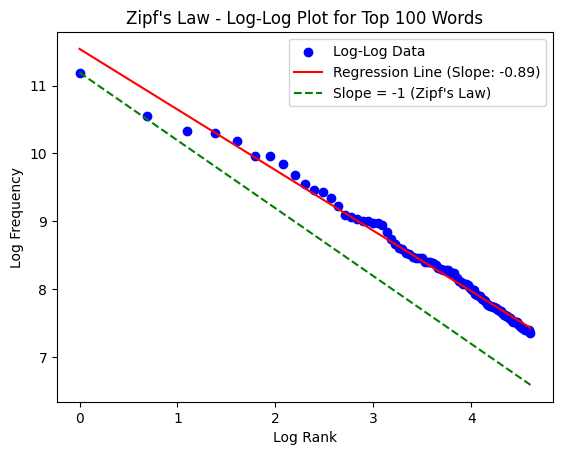

In [9]:
# Finding Ranks and Frequencies
ranks_100 = np.arange(1, len(top_words) + 1)
#print(ranks_100)

# Log Transformations
log_ranks_100 = np.log(ranks_100)
log_frequencies_100 = np.log(top_word_values)

# Econometric Regression
X_100 = sm.add_constant(log_ranks_100)
model_100 = sm.OLS(log_frequencies_100, X_100)
results_100 = model_100.fit()

# Graphing Results 
zipf_line_100 = log_frequencies_100[0] + (-1) * (log_ranks_100 - log_ranks_100[0])

plt.scatter(log_ranks_100, log_frequencies_100, color='blue', label='Log-Log Data')
plt.plot(log_ranks_100, results_100.predict(X_100), color='red', label=f'Regression Line (Slope: {results_100.params[1]:.2f})')
plt.plot(log_ranks_100, zipf_line_100, color='green', linestyle='--', label='Slope = -1 (Zipf\'s Law)')
plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')
plt.title('Zipf\'s Law - Log-Log Plot for Top 100 Words')
plt.legend()
plt.show()

### Does it follow zipf's law?
In summary, the plot econometrically supports Zipf's Law by showing that the relationship between the log of word rank and the log of word frequency is approximately linear with a slope close to -1. This suggests that the dataset follows a power-law distribution, which is consistent with Zipf's Law.

# Task B

In [10]:
mergedmakemodel = pd.read_csv('merged-1.csv')
mergedmakemodel = mergedmakemodel.drop(['Unnamed: 0'], axis = 1)
mergedmakemodel

,make,model
0,acura,cl
1,acura,ilx
2,acura,integra
3,acura,legend
4,acura,mdx
...,...,...
1725,volkswagen,volkwagen
1726,volkswagen,vw
1727,volkswagen,vws
1728,volkswagen,passats


In [11]:
stop_words = set(stopwords.words('english'))
model_to_brand = dict(zip(mergedmakemodel['model'].str.lower(), mergedmakemodel['make'].str.lower()))
brands_set = set(model_to_brand.values())

def replacements(message, model_to_brand, brands_set):
    if not isinstance(message, str):
        message = ''
    words = re.findall(r'\w+', message.lower())
    replaced_words = [model_to_brand.get(word, word) for word in words]
    return set([word for word in replaced_words if word not in stop_words and word in brands_set])

messages = df['Message']
brand_counter = Counter()

for message in messages:
    brands = replacements(message, model_to_brand, brands_set)
    brand_counter.update(brands)

brands_to_remove = ['car', 'sedan', 'problem', 'seat', 'mini']

for brand in brands_to_remove:
    brand_counter.pop(brand, None)

top_10 = brand_counter.most_common(10)

print("Top 10 Brands by Frequency:")
for brand, count in top_10:
    print(f"{brand.capitalize()}: {count}")

Brand_Counterdf = pd.DataFrame(brand_counter, columns = ['Brand', 'Count'])

Top 10 Brands by Frequency:
Infiniti: 11162
Lexus: 9380
Bmw: 5111
Acura: 3232
Polestar: 2365
Audi: 2234
Honda: 1691
Cadillac: 1319
Toyota: 1000
Nissan: 835


# Task C

In [27]:
# File paths
wordcounts_file = 'brand_counts.csv'
replacement_words_file = 'merged-1.csv'
input_file = 'replaced_data.csv'

def clean_text(text):
    # Remove punctuation, convert to lowercase, and remove stopwords
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['make'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts


def calculate_lift_for_brands(posts, top_brands, max_distance=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        brand_positions = {brand: [] for brand in top_brands}  # Track positions of top brands in the post

        # Record positions of the top brands in the post
        for index, word in enumerate(post):
            if word in top_brands:
                brand_positions[word].append(index)

        # Count brand frequencies (mention once per post, even if it appears multiple times)
        for brand in brand_positions:
            if brand_positions[brand]:  # If the brand appeared in the post
                word_frequency[brand] += 1

        # Check for co-occurrences within the max_distance
        for brand1, brand2 in itertools.combinations(top_brands, 2):
            if brand_positions[brand1] and brand_positions[brand2]:
                # Check if any pair of positions is within max_distance
                for pos1 in brand_positions[brand1]:
                    for pos2 in brand_positions[brand2]:
                        if abs(pos1 - pos2) <= max_distance:
                            word_pair_frequency[brand1][brand2] += 1
                            word_pair_frequency[brand2][brand1] += 1  # Ensure both directions are updated
                            break  # Only count once per post

    # Calculate lift values
    lift_values = []
    for brand1, brand2 in itertools.combinations(top_brands, 2):
        p_word1_and_word2 = word_pair_frequency[brand1][brand2] / total_posts
        p_word1 = word_frequency[brand1] / total_posts
        p_word2 = word_frequency[brand2] / total_posts
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            lift_values.append({'word1': brand1, 'word2': brand2, 'lift_value': lift_value})
            lift_values.append({'word1': brand2, 'word2': brand1, 'lift_value': lift_value})  # Symmetric value

    # Convert to DataFrame
    df_lift = pd.DataFrame(lift_values)

    # Format and print the lift matrix
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0

    print("\nFormatted Lift Matrix:\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift, lift_matrix

# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)
df_lift, lift_matrix = calculate_lift_for_brands(posts, top_brands)


Formatted Lift Matrix:

word2        acura      audi       bmw  cadillac     honda  infiniti     lexus    nissan  polestar    toyota
word1                                                                                                       
acura     0.000000  1.305416  0.691702  0.777237  1.555565  1.474570  1.298838  0.626996  0.464038  0.448055
audi      1.305416  0.000000  1.050984  1.281457  0.352790  1.131131  0.972045  0.302316  0.573422  0.224631
bmw       0.691702  1.050984  0.000000  0.881988  0.352385  1.218241  1.228950  0.273750  0.561806  0.378621
cadillac  0.777237  1.281457  0.881988  0.000000  0.244809  1.061159  1.191893  0.166168  0.314284  0.230475
honda     1.555565  0.352790  0.352385  0.244809  0.000000  0.722378  0.667641  1.542792  0.538704  2.337375
infiniti  1.474570  1.131131  1.218241  1.061159  0.722378  0.000000  1.215312  1.146625  0.681411  0.585008
lexus     1.298838  0.972045  1.228950  1.191893  0.667641  1.215312  0.000000  0.804066  0.541481  0.8

# Task D

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


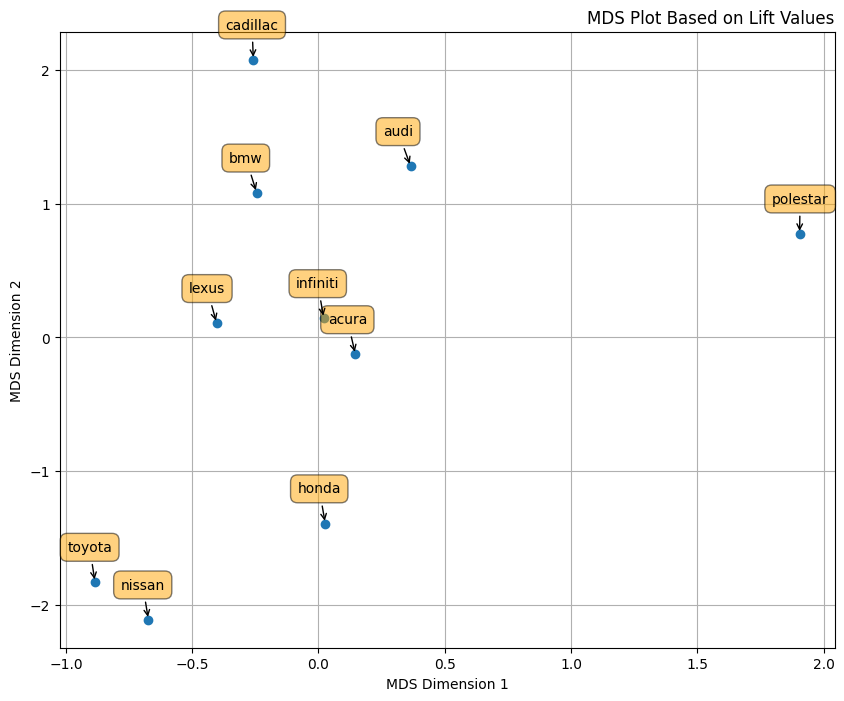

In [13]:
dissimilarity_matrix = 1 / (lift_matrix + 1e-10)
np.fill_diagonal(dissimilarity_matrix.values, 0)  # Set diagonal to zero

# Multidimensional Scaling (MDS)
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                   random_state=seed, dissimilarity="precomputed")

try:
    results = mds.fit(dissimilarity_matrix)
    coords = results.embedding_
    
except ValueError as e:
    print(f"Error during MDS fitting: {e}")
    coords = np.zeros((len(lift_matrix), 2))  # Placeholder in case of error

# Plotting the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

# Annotate each point with the corresponding brand name
for label, x, y in zip(lift_matrix.index, coords[:, 0], coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Left-align the title
plt.title('MDS Plot Based on Lift Values', loc='right')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()

# Task E

- 3 clusters of brands, 2 luxury, 1 entry level 
- polestar is an outlier
- lexus, infinity, accura are middle man brands entry level and luxury

# Task F

In [31]:
# File paths
wordcounts_file = 'brand_counts.csv'
replacement_words_file = 'merged-1.csv'
input_file = 'replaced_data.csv'

'''def clean_text(text):
    # Remove punctuation, convert to lowercase, and remove stopwords
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['make'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts
def calculate_lift_for_brands_attributes(posts, top_brands, attributes, max_distance=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand and attribute frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        brand_positions = {brand: [] for brand in top_brands}  # Track positions of top brands in the post
        attribute_positions = {attr: [] for attr in attributes}  # Track positions of attributes in the post

        # Record positions of the top brands and attributes in the post
        for index, word in enumerate(post):
            if word in top_brands:
                brand_positions[word].append(index)
            if word in attributes:
                attribute_positions[word].append(index)

        # Count brand frequencies (mention once per post, even if it appears multiple times)
        for brand in brand_positions:
            if brand_positions[brand]:  # If the brand appeared in the post
                word_frequency[brand] += 1

        # Check for co-occurrences within the max_distance between brands and attributes
        for brand, attribute in itertools.product(top_brands, attributes):
            if brand_positions[brand] and attribute_positions[attribute]:
                # Check if any pair of positions is within max_distance
                for pos1 in brand_positions[brand]:
                    for pos2 in attribute_positions[attribute]:
                        if abs(pos1 - pos2) <= max_distance:
                            word_pair_frequency[brand][attribute] += 1
                            break  # Only count once per post

    # Calculate lift values between brands and attributes
    lift_values = []
    for brand, attribute in itertools.product(top_brands, attributes):
        p_word1_and_word2 = word_pair_frequency[brand][attribute] / total_posts
        p_word1 = word_frequency[brand] / total_posts
        p_word2 = sum([attribute in post for post in posts]) / total_posts  # Frequency of attributes in all posts
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            lift_values.append({'brand': brand, 'attribute': attribute, 'lift_value': lift_value})

    # Convert to DataFrame
    df_lift = pd.DataFrame(lift_values)

    # Format and print the lift matrix
    lift_matrix = df_lift.pivot(index='brand', columns='attribute', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0

    print("\nFormatted Lift Matrix (Brand vs Attributes):\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift, lift_matrix


# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)
'''

def calculate_lift_for_brands_attributes(posts, top_brands, attributes, max_distance=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)
    total_attribute_count = defaultdict(int)

    # Count brand and attribute frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        brand_positions = {brand: [] for brand in top_brands}  # Track positions of top brands in the post
        attribute_positions = {attr: [] for attr in attributes}  # Track positions of attributes in the post

        # Record positions of the top brands and attributes in the post
        for index, word in enumerate(post):
            if word in top_brands:
                brand_positions[word].append(index)
            if word in attributes:
                attribute_positions[word].append(index)
                total_attribute_count[word] += 1  # Total frequency of each attribute

        # Count brand frequencies (mention once per post, even if it appears multiple times)
        for brand in brand_positions:
            if brand_positions[brand]:  # If the brand appeared in the post
                word_frequency[brand] += 1

        # Check for co-occurrences within the max_distance between brands and attributes
        for brand, attribute in itertools.product(top_brands, attributes):
            if brand_positions[brand] and attribute_positions[attribute]:
                # Check if any pair of positions is within max_distance
                for pos1 in brand_positions[brand]:
                    for pos2 in attribute_positions[attribute]:
                        if abs(pos1 - pos2) <= max_distance:
                            word_pair_frequency[brand][attribute] += 1
                            break  # Only count once per post

    # Calculate lift values between brands and attributes
    lift_values = []
    total_attribute_occurrences = sum(total_attribute_count.values())
    for brand, attribute in itertools.product(top_brands, attributes):
        p_word1_and_word2 = word_pair_frequency[brand][attribute] / total_posts
        p_word1 = word_frequency[brand] / total_posts
        p_word2 = total_attribute_count[attribute] / total_attribute_occurrences if total_attribute_occurrences > 0 else 0
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            lift_values.append({'brand': brand, 'attribute': attribute, 'lift_value': lift_value})

    # Convert to DataFrame
    df_lift = pd.DataFrame(lift_values)

    # Format and print the lift matrix
    lift_matrix = df_lift.pivot(index='brand', columns='attribute', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0

    print("\nFormatted Lift Matrix (Brand vs Attributes):\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift, lift_matrix


# These are the car-related attributes
attributes = ["speed", "comfort", "design", "performance", "price", "safety", "interior", "fuel", "handling", "reliability"]

# Calculate lift for brands and attributes
df_lift, lift_matrix = calculate_lift_for_brands_attributes(posts, top_brands, attributes)
# print(word_counts)




Formatted Lift Matrix (Brand vs Attributes):

attribute    design      fuel  handling  interior  performance     price  reliability    safety     speed
brand                                                                                                    
acura      0.265730  0.122438  0.257905  0.222335     0.229910  0.257827     0.218859  0.132865  0.241573
audi       0.308723  0.057051  0.233479  0.304820     0.161883  0.200563     0.354793  0.175411  0.210493
bmw        0.260581  0.215954  0.335107  0.243103     0.269268  0.319677     0.236118  0.050112  0.150335
cadillac   0.431938  0.019512  0.145882  0.556001     0.193049  0.221675     0.137888  0.000000  0.087260
honda      0.171382  0.153287  0.109671  0.182001     0.143077  0.197151     0.305283  0.171382  0.124641
infiniti   0.231703  0.177694  0.273798  0.390186     0.243393  0.306560     0.263253  0.230386  0.276463
lexus      0.383660  0.263068  0.346284  0.357954     0.342026  0.330363     0.406364  0.207577  0.274601

In [15]:
# Rank the brands for each attribute based on lift values
def rank_brands(row):
    # Sort the brands in descending order of lift values
    ranked_brands = row.sort_values(ascending=False).index.tolist()
    return ranked_brands

# Apply the ranking function to each row (attribute)
ranked_df = df_lift.apply(rank_brands, axis=1)

# Create a DataFrame with Rank 1 to Rank 10 columns
ranked_brands_df = pd.DataFrame(ranked_df.tolist(), 
                                index=ranked_df.index, 
                                columns=[f'Rank {i+1}' for i in range(10)])

# Display the final ranked DataFrame
print(ranked_brands_df)


               Rank 1    Rank 2    Rank 3    Rank 4    Rank 5  Rank 6  \
attribute                                                               
design       cadillac     lexus      audi    nissan     acura     bmw   
fuel            lexus       bmw  infiniti    toyota  polestar   honda   
handling        lexus       bmw  infiniti     acura    toyota    audi   
interior     cadillac  infiniti     lexus      audi    nissan     bmw   
performance     lexus       bmw  infiniti     acura  cadillac  toyota   
price           lexus       bmw  infiniti     acura  cadillac    audi   
reliability     lexus    toyota      audi     honda  infiniti     bmw   
safety       polestar    toyota    nissan  infiniti     lexus    audi   
speed        infiniti     lexus     acura      audi  polestar  nissan   

               Rank 7    Rank 8    Rank 9   Rank 10  
attribute                                            
design       infiniti    toyota     honda  polestar  
fuel            acura    nissan   

In [18]:
ranked_brands_df = ranked_brands_df.reset_index()
ranked_brands_df = ranked_brands_df.set_index('attribute')
ranked_brands_df

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6,Rank 7,Rank 8,Rank 9,Rank 10
attribute,,,,,,,,,,
design,cadillac,lexus,audi,nissan,acura,bmw,infiniti,toyota,honda,polestar
fuel,lexus,bmw,infiniti,toyota,polestar,honda,acura,nissan,audi,cadillac
handling,lexus,bmw,infiniti,acura,toyota,audi,cadillac,honda,polestar,nissan
interior,cadillac,infiniti,lexus,audi,nissan,bmw,acura,honda,toyota,polestar
performance,lexus,bmw,infiniti,acura,cadillac,toyota,audi,honda,nissan,polestar
price,lexus,bmw,infiniti,acura,cadillac,audi,honda,polestar,nissan,toyota
reliability,lexus,toyota,audi,honda,infiniti,bmw,polestar,acura,cadillac,nissan
safety,polestar,toyota,nissan,infiniti,lexus,audi,honda,acura,bmw,cadillac
speed,infiniti,lexus,acura,audi,polestar,nissan,bmw,honda,cadillac,toyota


# Task G 

# Task H

In [20]:
import pandas as pd
import re

# Example DataFrame (assuming 'Message' column contains your text data)
# df = pd.DataFrame({'Message': ['I want this car so much!', 'This is my dream car!', 'I love this car!']})

# List of aspirational phrases that indicate people are aspiring to have a brand
aspirational_phrases = [
    'i want this car', 'love', 'forever car', 'wish i had', 'dream car', 'desire', 'my favorite', 'aspire to'
]

# Precompile the aspirational phrases into a regex pattern for efficient searching
pattern = re.compile(r'\b(?:' + '|'.join(re.escape(phrase) for phrase in aspirational_phrases) + r')\b', re.IGNORECASE)

# Function to replace aspirational phrases with 'aspire', handling non-string values
def replace_aspirational_phrases(text):
    if isinstance(text, str):  # Check if the text is a string
        return pattern.sub('aspire', text)
    return text  # Return the original value if it's not a string

# Apply the function to the 'Message' column and create a new 'Aspire' column
df['Aspire'] = df['Message'].apply(replace_aspirational_phrases)




         Date                                            Message  \
0  03/23/2002  Entry level performance luxury sedans are a ho...   
1  03/24/2002  I personally think that with a few tweaks the ...   
2  03/25/2002  I am debating a new purchase and these two are...   
3  03/25/2002  Great handling, RWD, excellent engine and the ...   
4  03/25/2002  And no manual tranny. That may not matter to y...   

                                              Aspire  
0  Entry level performance luxury sedans are a ho...  
1  I personally think that with a few tweaks the ...  
2  I am debating a new purchase and these two are...  
3  Great handling, RWD, excellent engine and the ...  
4  And no manual tranny. That may not matter to y...  


In [21]:
# Display the updated DataFrame
df.head()

,Date,Message,Aspire
0,03/23/2002,Entry level performance luxury sedans are a ho...,Entry level performance luxury sedans are a ho...
1,03/24/2002,I personally think that with a few tweaks the ...,I personally think that with a few tweaks the ...
2,03/25/2002,I am debating a new purchase and these two are...,I am debating a new purchase and these two are...
3,03/25/2002,"Great handling, RWD, excellent engine and the ...","Great handling, RWD, excellent engine and the ..."
4,03/25/2002,And no manual tranny. That may not matter to y...,And no manual tranny. That may not matter to y...


In [25]:
import pandas as pd
import csv
import itertools
from collections import defaultdict
import re

# File paths
wordcounts_file = 'brand_counts.csv'
replacement_words_file = 'merged-1.csv'
input_file = 'replaced_data.csv'

# Function to clean text (remove punctuation, lowercase, etc.)
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

# Load word counts (from CSV)
def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Load replacement words (from CSV)
def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['make'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

# Get the top brands
def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

# Process the input file to extract posts
def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts

# Function to calculate occurrences of brands with "aspire"
def calculate_brand_aspire_occurrences(posts, top_brands):
    word_pair_frequency = defaultdict(int)
    total_posts = len(posts)

    target_word = 'aspire'

    # Count occurrences of brands with "aspire"
    for post in posts:
        brand_in_post = {brand for brand in post if brand in top_brands}
        if target_word in post:
            for brand in brand_in_post:
                word_pair_frequency[brand] += 1

    # Convert results to DataFrame
    result = pd.DataFrame({
        'brand': list(word_pair_frequency.keys()),
        'aspire_occurrences': list(word_pair_frequency.values())
    })

    # Sort by occurrences
    result = result.sort_values(by='aspire_occurrences', ascending=False)

    print("\nOccurrences of Brands with 'Aspire':\n")
    print(result.to_string(index=False))  # Print the DataFrame

    return result

# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)

# Calculate occurrences of brands with "aspire"
result_df = calculate_brand_aspire_occurrences(posts, top_brands)



Occurrences of Brands with 'Aspire':

Empty DataFrame
Columns: [brand, aspire_occurrences]
Index: []
